In [1]:
import sys, torch
import torch.nn.functional as F
import numpy as np
module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

from modules.set_configurations.set_config_gnn import config
from modules.data_generator.datagen_gnn import compute_node_idx_for_each_cluster
from modules.data_utils.read_data import get_sequence_data, extract_frame
from modules.compute_features.grid_features import grid_properties
from modules.set_configurations.common import reset_seed, get_device
from modules.neural_net.gnn.gnn_detector import Model_Training
from modules.compute_features.graph_features import (
    compute_adjacency_information, compute_node_features, compute_edge_features, select_moving_data)
from modules.data_utils.labels import compute_new_labels_to_id_dict, compute_old_to_new_label_id_map
from modules.compute_groundtruth.compute_node_labels import compute_ground_truth as compute_ground_truth_node
from modules.compute_groundtruth.compute_edge_labels import compute_ground_truth as compute_ground_truth_edge
from modules.compute_groundtruth.compute_offsets import unnormalize_gt_offsets
from modules.plot_utils.plot_func import plot_meas_and_gt_labels_cluster_centers, plot_graph, plot_edge_labels

config_file_path = 'configuration_radarscenes_gnn.yml'
config_obj = config(config_file_path)

reset_seed(config_obj.seed)
device = get_device()

detector_train = Model_Training(config_obj, device).to(device)

grid_obj = grid_properties(
    min_x = config_obj.min_x, max_x = config_obj.max_x, 
    min_y = config_obj.min_y, max_y = config_obj.max_y, 
    min_sigma_x = config_obj.min_sigma_x, max_sigma_x = config_obj.max_sigma_x, 
    min_sigma_y = config_obj.min_sigma_y, max_sigma_y = config_obj.max_sigma_y, 
    dx = config_obj.dx, dy = config_obj.dy)

initial_lr = 0.0005 #config_obj.learning_rate
wt_decay = config_obj.weight_decay
params = [p for p in detector_train.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, momentum=0.9, lr=initial_lr, weight_decay=wt_decay)

init_start = 0 # ==> start from this iteration  
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR( 
    optimizer, 
    gamma=0.1,
    milestones=[int(0.65 * config_obj.max_train_iter - init_start), 
                int(0.95 * config_obj.max_train_iter - init_start)])

GPU is available. Good to go!


In [2]:
sequence_name = 'sequence_108'
dataset_path = config_obj.dataset_path
window_size = config_obj.window_size
scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
    = get_sequence_data(dataset_rootdir, dataset_path, sequence_name, window_size)

data_dict = extract_frame(
    idx = 40, 
    windowed_data_list = scene_metadata,
    radar_mount_data = radar_mount_data,
    radar_data_all_scenes = radar_data_all_scenes,
    odometry_data_all_scenes = odometry_data_all_scenes,
    reject_outlier = False)

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()
gt_dict_node = compute_ground_truth_node(data_dict, labels_to_id_dict, old_to_new_label_id_map)
data_dict, gt_dict_node = grid_obj.select_meas_within_the_grid(data_dict, gt_dict_node)
data_dict_dyn, node_labels_dict_dyn = select_moving_data(data_dict, gt_dict_node, labels_to_id_dict)

ball_query_thresh = config_obj.ball_query_eps_square
k_number_nearest_points = config_obj.k_number_nearest_points
adj_dict_dyn = compute_adjacency_information(data_dict_dyn, ball_query_thresh, k_number_nearest_points)

# Node,Edge Feature and Label Computation
# ===============================================================================================================
other_features_dyn = np.stack((data_dict_dyn['meas_px'], data_dict_dyn['meas_py'], 
                               data_dict_dyn['meas_vx'], data_dict_dyn['meas_vy']), axis=-1)
edge_features_dyn = compute_edge_features(data_dict_dyn, adj_dict_dyn['adj_list'])
node_features_dyn = compute_node_features(data_dict_dyn, adj_dict_dyn['degree'])


node_features_dyn = compute_node_features(
        data_dict_dyn, adj_dict_dyn['degree'], 
        config_obj.include_region_confidence, 
        config_obj.grid_min_r, config_obj.grid_max_r, 
        config_obj.grid_min_th, config_obj.grid_max_th)

graph_features = {}
graph_features['other_features_dyn'] = torch.from_numpy(other_features_dyn).to(device).to(torch.float32)
graph_features['edge_features_dyn'] = torch.from_numpy(edge_features_dyn).to(device).to(torch.float32)
graph_features['node_features_dyn'] = torch.from_numpy(node_features_dyn).to(device).to(torch.float32)
graph_features['edge_index_dyn'] = torch.from_numpy(adj_dict_dyn['adj_list'] ).to(device).to(torch.int64)
graph_features['adj_matrix_dyn'] = torch.from_numpy(adj_dict_dyn['adj_matrix'] ).to(device).to(torch.bool)

edge_labels_dyn = compute_ground_truth_edge(data_dict_dyn, adj_dict_dyn['adj_list'], adj_dict_dyn['adj_matrix'])
gt_labels_dyn = node_labels_dict_dyn['class_labels']
gt_offsets_dyn = np.stack([node_labels_dict_dyn['offsetx'], node_labels_dict_dyn['offsety']], axis=-1)

# label dictionary
labels = {}
labels['edge_class'] = torch.from_numpy(edge_labels_dyn).to(device).to(int)
labels['node_class'] = torch.from_numpy(gt_labels_dyn).to(device).to(int)
labels['node_offsets'] = torch.from_numpy(gt_offsets_dyn).to(device).to(torch.float32)

cluster_node_idx, cluster_labels = compute_node_idx_for_each_cluster(data_dict_dyn['meas_trackid'], gt_labels_dyn, device)
labels['cluster_node_idx'] = cluster_node_idx
labels['cluster_labels'] = cluster_labels

# print(labels['cluster_labels'])
# print(labels['cluster_node_idx'])

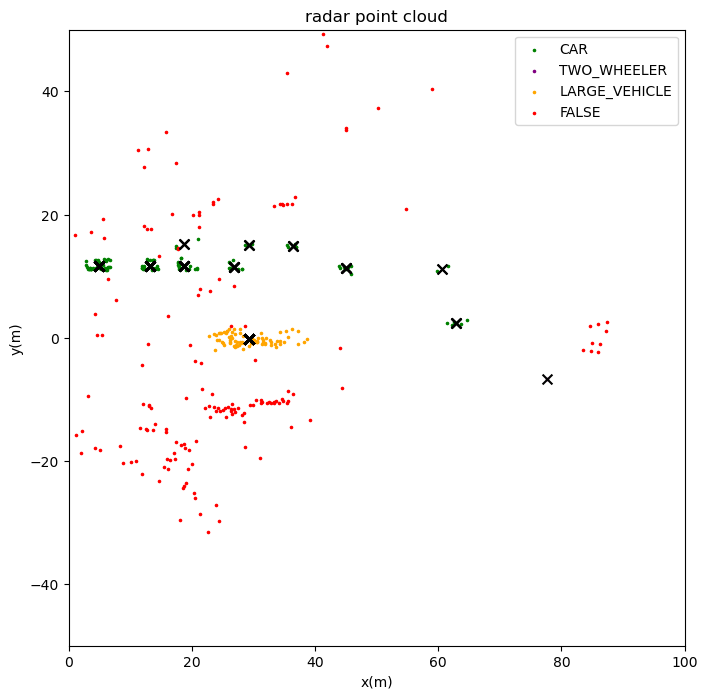

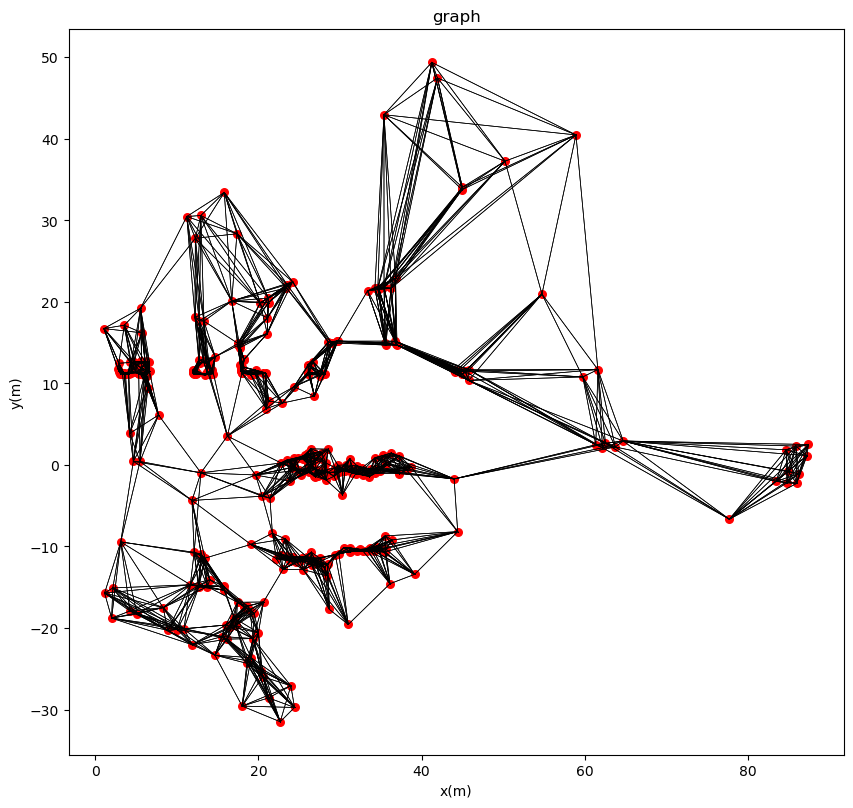

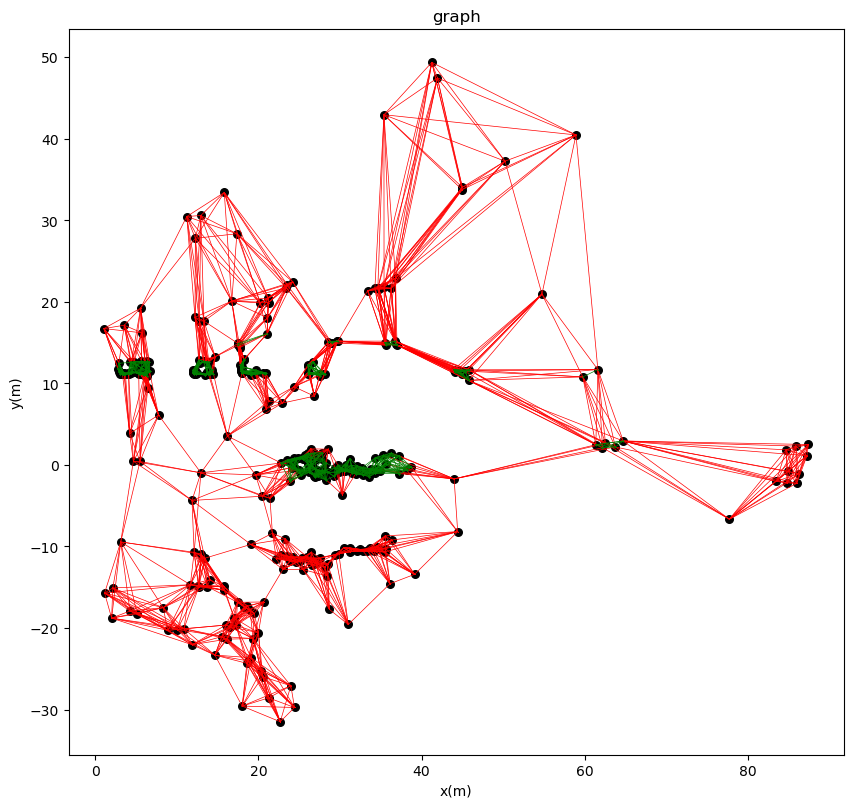

In [3]:
edge_features = graph_features['edge_features_dyn'].detach().cpu().numpy()
node_features = graph_features['node_features_dyn'].detach().cpu().numpy()
other_features = graph_features['other_features_dyn'].detach().cpu().numpy()
edge_index = graph_features['edge_index_dyn'].detach().cpu().numpy()
adj_matrix = graph_features['adj_matrix_dyn'].detach().cpu().numpy()
edge_index = edge_index.astype(int)
edge_class = labels['edge_class'].detach().cpu().numpy()
node_class = labels['node_class'].detach().cpu().numpy()
node_offsets = labels['node_offsets'].detach().cpu().numpy()

vr = node_features[:, 0]
rcs = node_features[:, 1]
t = node_features[:, 2]
degree = node_features[:, 3]
px = other_features[:, 0]
py = other_features[:, 1]
vx = other_features[:, 2]
vy = other_features[:, 3]

cluster_centers_x = px + node_offsets[:,0]
cluster_centers_y = py + node_offsets[:,1]

all_labels_dyn = config_obj.object_classes_dyn
flag = node_class != config_obj.new_labels_to_id_dict_dyn['FALSE']
plot_meas_and_gt_labels_cluster_centers(
    px, py, cluster_centers_x[flag], cluster_centers_y[flag], 
    node_class, all_labels_dyn , figsize = (8, 8))

plot_graph(px, py, edge_index, figsize=(10, 10))

valid_row_idx, valid_col_idx = np.nonzero(np.triu(adj_matrix, k=1))
edge_index = np.stack((valid_row_idx, valid_col_idx), axis=0)
plot_edge_labels(px, py, edge_index, edge_class, figsize=(10, 10))

In [4]:
graph_features_batch = {}
graph_features_batch['other_features_dyn'] = [graph_features['other_features_dyn']]
graph_features_batch['node_features_dyn'] = [graph_features['node_features_dyn']]
graph_features_batch['edge_features_dyn'] = [graph_features['edge_features_dyn']]
graph_features_batch['edge_index_dyn'] = [graph_features['edge_index_dyn']]
graph_features_batch['adj_matrix_dyn'] = [graph_features['adj_matrix_dyn']]
    
labels_batch = {}
labels_batch['edge_class'] = [labels['edge_class']]
labels_batch['node_class'] = [labels['node_class']]
labels_batch['node_offsets'] = [labels['node_offsets']]
labels_batch['cluster_node_idx'] = [labels['cluster_node_idx']]
labels_batch['cluster_labels'] = [labels['cluster_labels']]

max_iters = 2000
iter_start_offset = 0
for iter_train_outer in range(iter_start_offset, max_iters):

    loss, acc = detector_train(
        node_features = graph_features_batch['node_features_dyn'],
        edge_features = graph_features_batch['edge_features_dyn'],
        edge_index = graph_features_batch['edge_index_dyn'],
        adj_matrix = graph_features_batch['adj_matrix_dyn'],
        labels = labels_batch )
    
    # if iter_train_outer % 2 == 0: total_loss = loss['loss_node_cls'] + loss['loss_node_reg']
    # else: total_loss = loss['loss_node_cls'] + loss['loss_edge_cls']
    total_loss = loss['loss_node_cls'] + loss['loss_node_reg'] + loss['loss_edge_cls'] + loss['loss_obj_cls']

    total_loss.backward()
    optimizer.step()
    lr_scheduler.step()  
    optimizer.zero_grad()

    loss_str = f"[Iter {iter_train_outer}][loss: {total_loss.item():.8f}]"
    for key, value in loss.items():
        loss_str += f"[{key}: {value.item():.8f}]"
    print(loss_str)

[Iter 0][loss: 5.84516382][loss_node_cls: 1.49828529][loss_node_reg: 0.23198010][loss_edge_cls: 2.27663517][loss_obj_cls: 1.83826315]
[Iter 1][loss: 5.82030010][loss_node_cls: 1.49615264][loss_node_reg: 0.22353530][loss_edge_cls: 2.27416420][loss_obj_cls: 1.82644808]
[Iter 2][loss: 5.77588749][loss_node_cls: 1.49211907][loss_node_reg: 0.21014182][loss_edge_cls: 2.26947689][loss_obj_cls: 1.80414963]
[Iter 3][loss: 5.71815300][loss_node_cls: 1.48640501][loss_node_reg: 0.19625676][loss_edge_cls: 2.26280546][loss_obj_cls: 1.77268565]
[Iter 4][loss: 5.65267467][loss_node_cls: 1.47921491][loss_node_reg: 0.18565752][loss_edge_cls: 2.25436783][loss_obj_cls: 1.73343420]
[Iter 5][loss: 5.58315468][loss_node_cls: 1.47074425][loss_node_reg: 0.18035880][loss_edge_cls: 2.24435902][loss_obj_cls: 1.68769288]
[Iter 6][loss: 5.51125050][loss_node_cls: 1.46117771][loss_node_reg: 0.18036565][loss_edge_cls: 2.23296404][loss_obj_cls: 1.63674295]
[Iter 7][loss: 5.43682194][loss_node_cls: 1.45071447][loss_nod

In [5]:
# compute and extract predictions
detector = detector_train.pred.eval()
pred_node_class_logits, pred_node_reg_deltas, pred_edge_class_logits, obj_cls_predictions = detector(
        node_features = graph_features_batch['node_features_dyn'][0],
        edge_features = graph_features_batch['edge_features_dyn'][0],
        edge_index = graph_features_batch['edge_index_dyn'][0],
        adj_matrix = graph_features_batch['adj_matrix_dyn'][0],
        cluster_node_idx = labels_batch['cluster_node_idx'][0])

# compute object class prediction
obj_cls_prob = F.softmax(obj_cls_predictions, dim=-1)
obj_cls_score, obj_cls_idx = torch.max(obj_cls_prob, dim=-1)
print(f"object class predictions: {obj_cls_idx}")
print(f"object class GT         : {labels_batch['cluster_labels'][0]}")

# compute node class and edge class prediction
cls_prob = F.softmax(pred_node_class_logits, dim=-1)
edge_cls_prob= F.softmax(pred_edge_class_logits, dim=-1)
edge_cls_score, edge_cls_idx = torch.max(edge_cls_prob, dim=-1)
cls_score, cls_idx = torch.max(cls_prob, dim=-1)

# compute offsets
offset_mu = config_obj.reg_mu
offset_sigma = config_obj.reg_sigma
reg_deltas = unnormalize_gt_offsets(pred_node_reg_deltas, offset_mu, offset_sigma)
cluster_centers_xy = graph_features_batch['other_features_dyn'][0][:, :2] + reg_deltas

object class predictions: tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6], device='cuda:0')
object class GT         : tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6

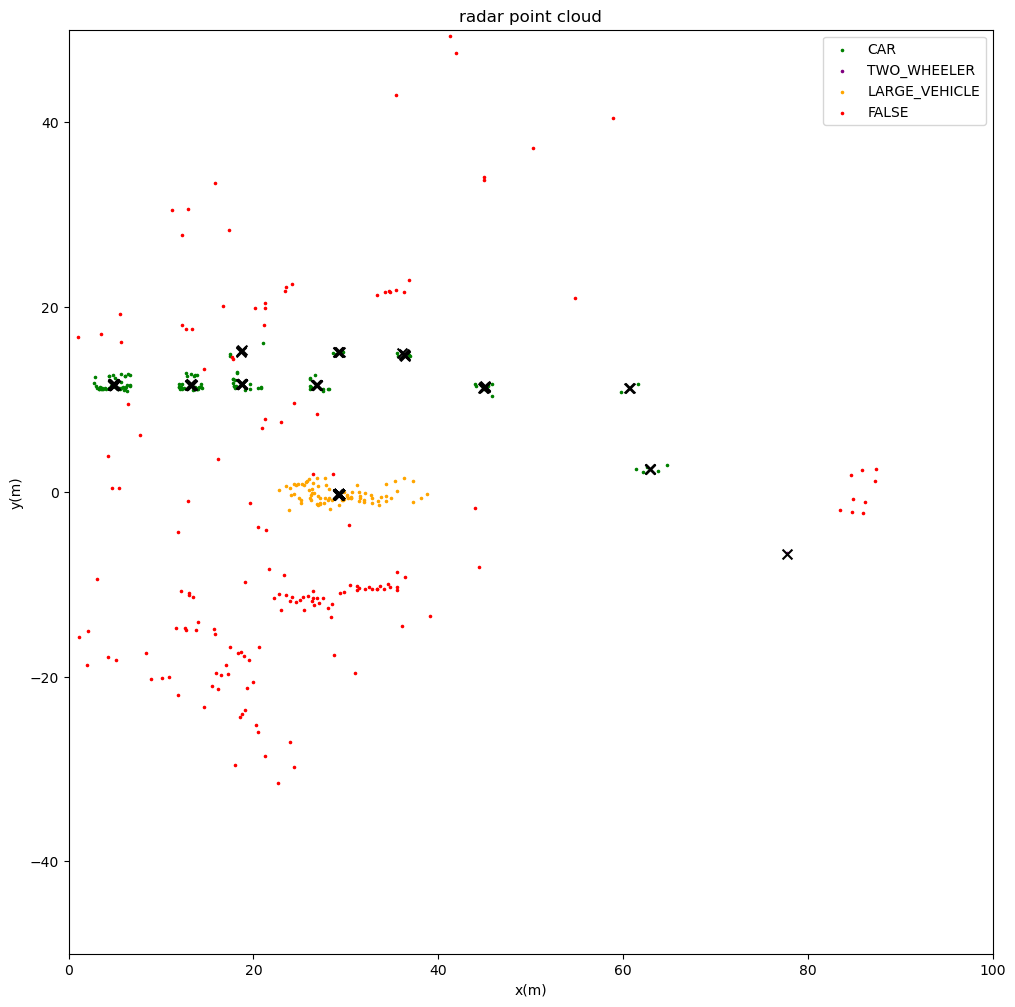

In [6]:
all_labels = config_obj.object_classes_dyn
px = graph_features_batch['other_features_dyn'][0][:, 0]
py = graph_features_batch['other_features_dyn'][0][:, 1]
flag = cls_idx != config_obj.new_labels_to_id_dict_dyn['FALSE']
plot_meas_and_gt_labels_cluster_centers(
    px.detach().cpu().numpy(), 
    py.detach().cpu().numpy(), 
    cluster_centers_xy[:,0][flag].detach().cpu().numpy(), 
    cluster_centers_xy[:,1][flag].detach().cpu().numpy(), 
    cls_idx.detach().cpu().numpy(), all_labels , figsize = (12, 12))

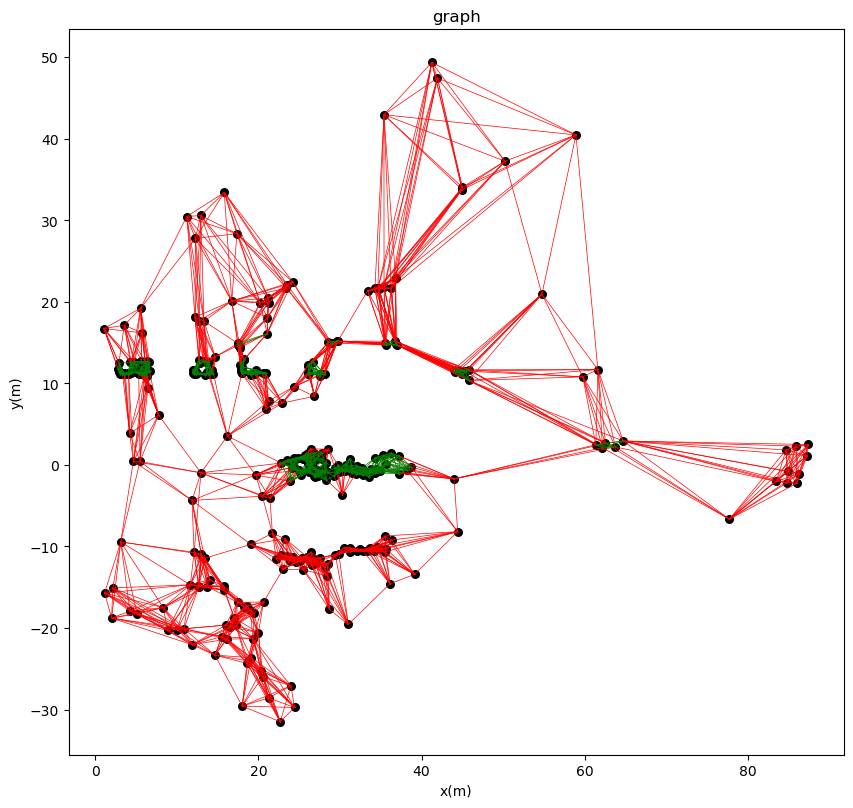

In [7]:
adj_matrix = graph_features_batch['adj_matrix_dyn'][0]
valid_row_idx, valid_col_idx = torch.nonzero(torch.triu(adj_matrix, diagonal=1), as_tuple=True)
edge_index = torch.stack((valid_row_idx, valid_col_idx), axis=0)
plot_edge_labels(
    px.detach().cpu().numpy(), 
    py.detach().cpu().numpy(), 
    edge_index.detach().cpu().numpy(), 
    edge_cls_idx.detach().cpu().numpy(), 
    figsize=(10, 10))

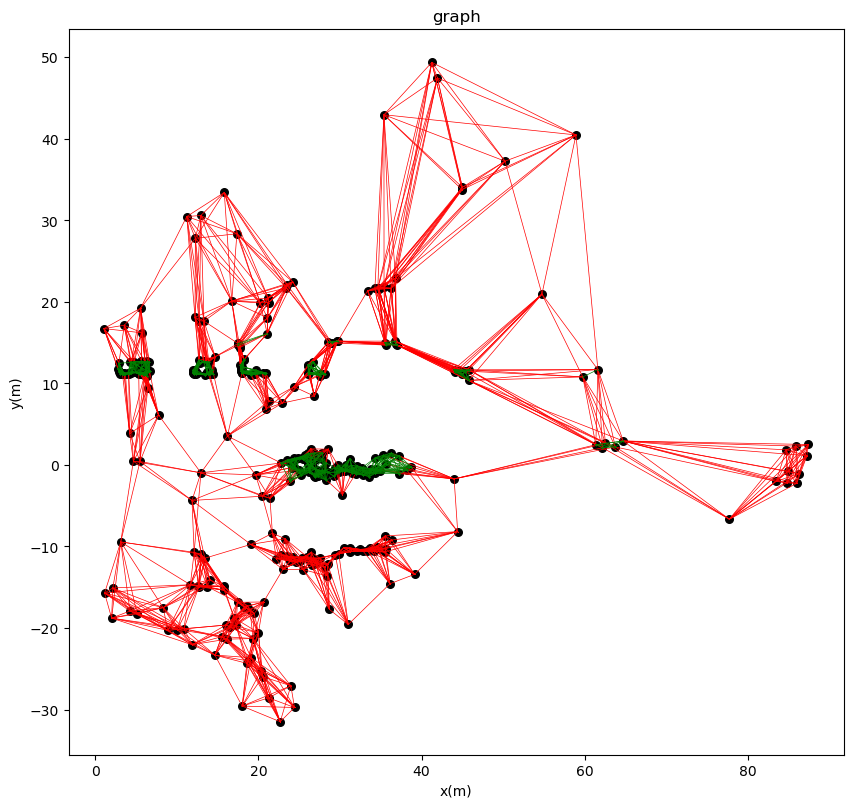

In [8]:
adj_matrix = graph_features_batch['adj_matrix_dyn'][0]
valid_row_idx, valid_col_idx = torch.nonzero(torch.triu(adj_matrix, diagonal=1), as_tuple=True)
edge_index = torch.stack((valid_row_idx, valid_col_idx), axis=0)
plot_edge_labels(
    px.detach().cpu().numpy(), 
    py.detach().cpu().numpy(), 
    edge_index.detach().cpu().numpy(), 
    labels_batch['edge_class'][0].cpu().numpy(),
    figsize=(10, 10))